# Agresti & Finlay: Robust Regression

Here, we will demonstrate robust regression using data from *Statistical Methods for Social Sciences*, 3rd Edition by Alan Agresti and Barbara Finlay. We will model violent crime as a function of poverty and percent of population that are single parents. Note that this analysis is all at the state-level for the United States. This applied example is based on the [tutorial](https://stats.oarc.ucla.edu/r/dae/robust-regression/) provided by UCLA Advanced Research Computing. The data come from the 2005 *Statistical Abstract of the United States*, with a copy of the data available [here](https://users.stat.ufl.edu/~aa/social/data.html).

## Setup

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import delicatessen
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_regression, ee_robust_regression
from delicatessen.utilities import robust_loss_functions

print("Versions")
print("NumPy:       ", np.__version__)
print("SciPy:       ", sp.__version__)
print("pandas:      ", pd.__version__)
print("Matplotlib:  ", mpl.__version__)
print("Delicatessen:", delicatessen.__version__)

Versions
NumPy:        1.25.2
SciPy:        1.11.2
pandas:       1.4.1
Matplotlib:   3.9.2
Delicatessen: 4.0


In [2]:
d = pd.read_stata("data/crime.dta")
d['intercept'] = 1
d['crime_std'] = (d['crime'] - np.mean(d['crime'])) / np.std(d['crime'], ddof=1)

In [3]:
X = np.asarray(d[['intercept', 'poverty', 'single']])
y = np.asarray(d['crime_std'])

Let's examine the outcome variable to see if there are substantial outliers

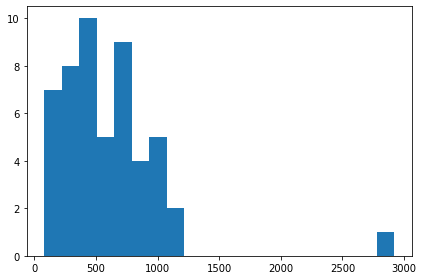

In [4]:
plt.hist(d['crime'], bins=20)
plt.tight_layout()

In [5]:
print(d.loc[d['crime'] == np.max(d['crime']), ['state', 'crime']])

   state  crime
50    dc   2922


So in this data set, Washington DC has a quite substantial crime rate relative to other locations. This indicates there is a substantial outlier, and our subsequent results may depend on how DC is handled in the analysis.

## Linear Regression

To start, let's model crime rate (`crime`) as a function of poverty (`poverty`) and single parent percentage (`single`). This can be easily done in `delicatessen` by constructing the estimating functons using the `ee_regression` 

In [6]:
def psi_ols(theta):
    return ee_regression(theta, X=X, y=y, model='linear')

In [7]:
estr = MEstimator(psi_ols, init=[0, 0, 0])
estr.estimate()
estr.print_results()

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          51 | No. Parameters:              3
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -4.49     0.63    -7.17    -5.72    -3.26     0.00    40.25 
    0.02     0.02     0.64    -0.03     0.06     0.52     0.94 
    0.38     0.06     6.54     0.26     0.49     0.00    33.89 


To understand our results a bit more, we can plot the residuals

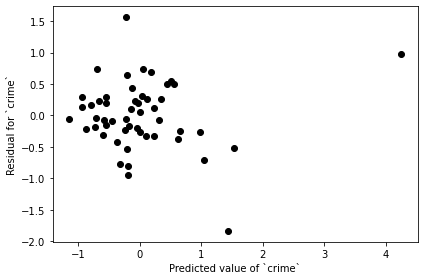

In [8]:
yhat = np.dot(X, estr.theta)

plt.plot(yhat, y - yhat, 'o', color='k')
plt.xlabel("Predicted value of `crime`")
plt.ylabel("Residual for `crime`")
plt.tight_layout()

From this plot, we can see there are a few potential outliers. The problem with outliers is that they can have substantial influence on our results. The estimating equation is actually helpful for seeing why this is the case. For our linear regression model, we can the following stack of estimating functions
$$ E[\psi(O_i; \theta)] = E
\begin{bmatrix} 
  (Y_i - \hat{Y}_i) \\
  (Y_i - \hat{Y}_i) P_i \\
  (Y_i - \hat{Y}_i) S_i \\
\end{bmatrix}
= 0
$$
where $Y$ is the crime rate, $P$ is poverty, $S$ the proportion of single parents, and $\hat{Y}_i = \theta_0 + \theta_1 P_i + \theta_2 S_i$ is the predicted value of the crime rate from the model. Let's focus on the intercept to simplify our discussion. To solve this estimating equation, we want to find the values of $\theta$ where
$$ E[Y_i - \hat{Y}_i] = 0 $$
or we want to find where the mean of the residuals is zero. So, if there is a very large value of $Y$ (relative to the other observations) it can substantially influence the estimate of the final results. This view of the residuals (and outliers influence) helps to build intuition behind robust regression

## Robust Regression

The methods considered here all operate by limiting the influence of the residuals. Specifically, we specify a function $f$ that takes the residuals and returns values that are more 'well behaved'. To see how this works, let's plot how the residuals vary under different choices of  $f$. Starting with linear regression, $f$ is simply the identity function, so let's plot that as a referent

In [9]:
resid = np.linspace(-3, 3, 100)

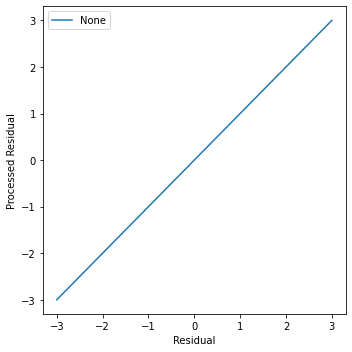

In [10]:
plt.figure(figsize=[5, 5])
plt.plot(resid, resid, '-', label='None')
plt.legend()
plt.xlabel("Residual")
plt.ylabel("Processed Residual")
plt.tight_layout()

One of the first proposed robust function was by Huber, hence its name. The Huber robust function caps the maximum contribution to the estimating equations at a maximum for each observation. So, the contributions to the estimating function are capped at a user-set level `k`. Let's plot this function along with the identity function from before

In [11]:
resid_h = robust_loss_functions(resid, loss='huber', k=1)

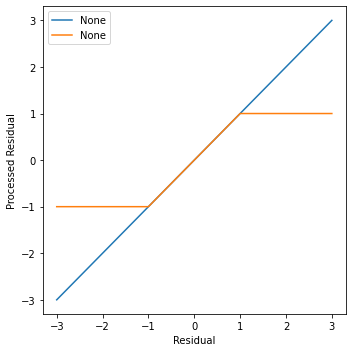

In [12]:
plt.figure(figsize=[5, 5])
plt.plot(resid, resid, '-', label='None')
plt.plot(resid, resid_h, '-', label='None')
plt.legend()
plt.xlabel("Residual")
plt.ylabel("Processed Residual")
plt.tight_layout()

So how much any observation can shift the solution is limited. There are many other ways to constrain the contributions to the loss function. Those implemented in `delicatessen` are shown in the following plot

In [13]:
resid_a = robust_loss_functions(resid, loss='andrew', k=1)
resid_t = robust_loss_functions(resid, loss='tukey', k=1)
resid_f = robust_loss_functions(resid, loss='fair', k=1)
resid_c = robust_loss_functions(resid, loss='cauchy', k=1)
resid_u = robust_loss_functions(resid, loss='ullah', k=1)
resid_w = robust_loss_functions(resid, loss='welsch', k=1)
resid_hmpl = robust_loss_functions(resid, loss='hampel', k=2, a=0.667, b=1.333)

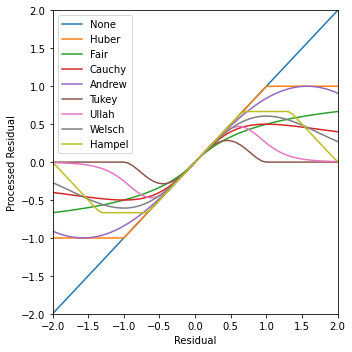

In [14]:
plt.figure(figsize=[5, 5])
plt.plot(resid, resid, '-', label='None')
plt.plot(resid, resid_h, '-', label='Huber')
plt.plot(resid, resid_f, '-', label='Fair')
plt.plot(resid, resid_c, '-', label='Cauchy')
plt.plot(resid, resid_a, '-', label='Andrew')
plt.plot(resid, resid_t, '-', label='Tukey')
plt.plot(resid, resid_u, '-', label='Ullah')
plt.plot(resid, resid_w, '-', label='Welsch')
plt.plot(resid, resid_hmpl, '-', label='Hampel')
plt.legend()
plt.xlabel("Residual")
plt.xlim([-2, 2])
plt.ylabel("Processed Residual")
plt.ylim([-2, 2])
plt.tight_layout()

So how contributions are constrained varies quite a bit between methods, with some placing a cap and others further shrinking the contributions of outliers to zero. For the functions underlying each of these robust functions, see the reference documentation for `robust_loss_functions` in Utilities.

Also note that each robust loss functions has different recommendations for the tuning parameter `k`. Here, `k` is set to be equal for display purposes

## Robust Regression

Now we will illustrate each of the robust regression methods with the applied example. 

### Huber 
First, let's examine Huber robust regression. While `k=1.345` is commonly recommended, I chose a value of `k=1` based on our residual plot. 

In [15]:
def psi_huber(theta):
    return ee_robust_regression(theta, X=X, y=y, model='linear', 
                                loss='huber', k=1)


estr = MEstimator(psi_huber, init=[0, 0, 0])
estr.estimate()
estr.print_results()

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          51 | No. Parameters:              3
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -4.67     0.53    -8.76    -5.71    -3.62     0.00    58.84 
    0.02     0.02     0.96    -0.02     0.06     0.34     1.58 
    0.39     0.05     7.73     0.29     0.49     0.00    46.42 


These results are broadly similar to linear regression. However, the intercept is slightly different and the standard errors are slightly smaller. 

### Fair

Like Huber, the Fair robust function is monotonic. Unlike the Huber, it continually tapers the contributions and doesn't have a sharp 'hinge' point. Again, the same value of `k` was selected as for Huber

In [16]:
def psi_fair(theta):
    return ee_robust_regression(theta, X=X, y=y, model='linear', 
                                loss='fair', k=1)


estr = MEstimator(psi_fair, init=[0, 0, 0])
estr.estimate()
estr.print_results()

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          51 | No. Parameters:              3
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -4.56     0.77    -5.89    -6.08    -3.04     0.00    27.95 
    0.02     0.02     0.86    -0.02     0.06     0.39     1.36 
    0.38     0.07     5.19     0.24     0.52     0.00    22.18 


These results are quite similar to the others. However, the variance for the intercept is noticeably larger than the other methods considered thus far.

### Cauchy

As a transition to the next general category of robust functions, let's consider the Cauchy robust function. As shown in the plot, after a certain point the Cauchy function begins to reduce the influence of outliers. However, these are not shrunk to zero. Here, we are going to set `k=1` again. This choice has less clear of a motivation that the previous. To see how outliers are changed, see the previous plot

In [17]:
def psi_cauchy(theta):
    return ee_robust_regression(theta, X=X, y=y, model='linear', 
                                loss='cauchy', k=1)


estr = MEstimator(psi_cauchy, init=[0, 0, 0])
estr.estimate()
estr.print_results()

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          51 | No. Parameters:              3
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -4.67     0.95    -4.92    -6.54    -2.81     0.00    20.12 
    0.02     0.02     1.00    -0.02     0.06     0.32     1.65 
    0.39     0.09     4.32     0.21     0.56     0.00    15.96 


These results are again similar but we see an increase in the standard error.

### Andrew's Sine

Next, is Andrew's Sine, which allows for the same maximum influence as for `k` as Huber. However, it varies smoothly and decreases outlier's impact to zero at high levels. Again, `k=1` is chosen here

In [18]:
def psi_sine(theta):
    return ee_robust_regression(theta, X=X, y=y, model='linear', 
                                loss='andrew', k=1)


estr = MEstimator(psi_sine, init=[0, 0, 0])
estr.estimate()
estr.print_results()

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          51 | No. Parameters:              3
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -2.32     0.41    -5.65    -3.13    -1.52     0.00    25.92 
    0.02     0.02     0.80    -0.02     0.06     0.42     1.24 
    0.18     0.05     3.61     0.08     0.28     0.00    11.65 


Here, we see a change in our coefficients. The coefficient for single-parents is fairly different. As a result, the intercept also shifts around a bit. This is the first method we've seen so far that led to a change in the coefficients

### Welsch

Next, consider the Welsch robust function. This function has a similar overall shape to Andrew's Sine but it's steepness and values change when set to the same `k`. Here, `k=1` is again chosen for convenience.

In [19]:
def psi_welsch(theta):
    return ee_robust_regression(theta, X=X, y=y, model='linear', 
                                loss='welsch', k=1)


estr = MEstimator(psi_welsch, init=[0, 0, 0])
estr.estimate()
estr.print_results()

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          51 | No. Parameters:              3
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -4.78     0.68    -7.07    -6.11    -3.46     0.00    39.20 
    0.02     0.02     1.10    -0.02     0.07     0.27     1.89 
    0.39     0.06     6.18     0.27     0.52     0.00    30.51 


These results are similar to the others

### Ullah

Next is the Ullah robust loss function. It again shares a similar shape to the previous two functions. 

In [20]:
def psi_ullah(theta):
    return ee_robust_regression(theta, X=X, y=y, model='linear', 
                                loss='ullah', k=1)


estr = MEstimator(psi_ullah, init=[0, 0, 0])
estr.estimate()
estr.print_results()

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          51 | No. Parameters:              3
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -4.11     0.87    -4.72    -5.82    -2.40     0.00    18.69 
    0.02     0.02     1.14    -0.02     0.06     0.26     1.97 
    0.33     0.09     3.70     0.16     0.51     0.00    12.18 


Results are fairly similar to many of the other methods

### Tukey's Biweight

Next, we consider Tukey's biweight robust function. As shown in the previous plot, this function substantially reduces the influence of observations when set to the same value of `k` as other robust functions. When running this example, small values of `k` produce massive standard errors. Further, this model was quite sensitive to the intial starting values (not shown). These suggest some instability from the double square in the function. Here, `k=5` since this limited the extreme behavior

In [21]:
def psi_tukey(theta):
    return ee_robust_regression(theta, X=X, y=y, model='linear', 
                                loss='tukey', k=5)


estr = MEstimator(psi_tukey, init=[0, 0, 0])
estr.estimate()
estr.print_results()

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          51 | No. Parameters:              3
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -4.55     0.65    -7.03    -5.82    -3.28     0.00    38.79 
    0.02     0.02     0.76    -0.03     0.06     0.45     1.16 
    0.38     0.06     6.44     0.26     0.50     0.00    32.92 


After this bit of tuning, the results are quite similar to the other approaches.

### Hampel

The final robust function considered is the Hampel robust function. Like the most recent robust functions considered, it decreases contributions to estimation beyond a certain point. Unlike the previous, this function has straight lines for the contributions. Therefore, it mimics the Huber robust function until a set point. Then it decreases that function down to zero linearly. 

Unlike the previous functions, the Hampel robust loss function takes 3 parameters. Here, `k` is the point that the influence of observations goes down to zero, `lower` sets the first hinge, or plateau, and `upper` sets the upper limit on the influence of observations

In [22]:
def psi_hampel(theta):
    return ee_robust_regression(theta, X=X, y=y, model='linear', 
                                loss='hampel', k=2, lower=1/3, upper=4/3)


estr = MEstimator(psi_hampel, init=[0, 0, 0])
estr.estimate()
estr.print_results()

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          51 | No. Parameters:              3
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -3.61     4.28    -0.84   -12.00     4.79     0.40     1.32 
    0.02     0.03     0.84    -0.03     0.08     0.40     1.31 
    0.28     0.43     0.66    -0.55     1.12     0.51     0.98 


Here, results for single parent lie between Huber and Andrew's Sine. 

This completes the illustration of robust linear regression using `delicatessen`. The `robust_loss_functions` can be used to compute these quantities so users are able to construct their own robust estimating functions.